Topmatter

In [1]:
import astropy.constants as const
import astropy.units as u
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from plasmapy.diagnostics import proton_radiography as prad

Load an example 3D grid of fields included in the package. This example contains the radial electric field created by a Gaussian sphere of electric charge.

Generating Electrostatic Gaussian Sphere


Text(0.5, 0.92, 'Gaussian Potential Electric Field')

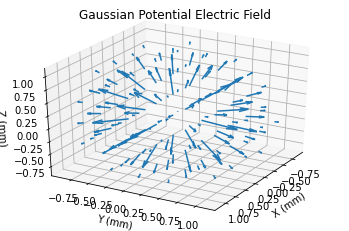

In [2]:
grid, E, B = prad.test_fields(mode='electrostatic gaussian sphere')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,30)

s = slice(None,None,20) # Plot only every 6th point
ax.quiver(grid[s,s,s,0].to(u.mm).value, grid[s,s,s,1].to(u.mm).value,  grid[s,s,s,2].to(u.mm).value,
           E[s,s,s,0].value, E[s,s,s,1].value, E[s,s,s,2].value, length=1e-10)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_title("Gaussian Potential Electric Field")

Prior to running the particle tracing algorithm, the simulation instance must be instatiated by providing some information about the setup, including:
    - The location of the proton souce with respect to the origin of the field grid. Only point sources are supported. 
    
    - The location of the center of the detector plane. The vector from this point to the origin of the field grid defines the normal vector of the detector plane. The horizontal axis of the detector plane is defined to be orthoganal to the z-axis of the field grid.
    
    - The energy of the protons. Lower energy protons will undergo more severe deflections.
    
The source and detector coordinates are entered as a 3-tuple in one of three coordinate systems: cartesian (x,y,z), spherical (r, theta, phi) or cylindrical (r, theta, z). All values should be astropy Quantities with units of either length or angle (degrees or radians) as appropriate. Note that, in general, the vector from the source to the detector should pass through the origin.

In [3]:
source = (0*u.mm, 0*u.mm, -10*u.mm)
detector = (0*u.mm, 0*u.mm, 100*u.mm)

sim = prad.SimPrad(grid, E, B, source, detector, 
                   proton_energy=14*u.MeV, geometry='cartesian')

In order to run the simulation, a number of simulated particles must be selected (nparticles). The simulation timestep is automatically (and adaptively) calculated based on the proton energy, grid resolution, and field amplitudes, but a multiplier (dt_mult) may be set with caution to modify these values.

In [4]:
print(grid.shape)
sim.run(nparticles=1e5, dt_mult=20, max_theta = np.pi/4*u.rad)

(250, 250, 250, 3)
Creating Particles
0.0% on grid
0.0% on grid

C:\Users\Peter\Anaconda3\envs\plasmapy\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



17.4% on grid
33.0% on grid
47.2% on grid
60.2% on grid
72.1% on grid
83.0% on grid
93.2% on grid
100.0% on grid
99.1% on grid
88.7% on grid
76.6% on grid
64.8% on grid
53.4% on grid
33.6% on grid
14.8% on grid
3.3% on grid
[ 0.0010318  -0.00328214  0.00295379] m
[ 0.01678166 -0.05338205  0.1       ] m
Run completed


At the end of the simulation run, all particles are allowed to coast until they reach the detector plane.

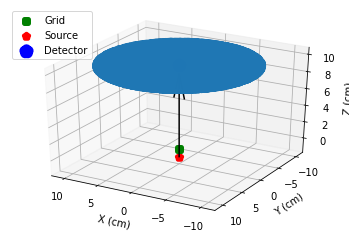

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,120)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')



# Plot the source-to-detector axis
ax.quiver(sim.source[0].to(u.cm).value, 
          sim.source[1].to(u.cm).value,
          sim.source[2].to(u.cm).value,
          sim.detector[0].to(u.cm).value, 
          sim.detector[1].to(u.cm).value,
          sim.detector[2].to(u.cm).value, color='black')   

# Plot the simulation field grid volume
ax.scatter(0,0,0, color='green', marker='s', linewidth=5, label='Grid')

# Plot the the proton source and detector plane locations
ax.scatter(sim.source[0].to(u.cm).value, 
           sim.source[1].to(u.cm).value,
           sim.source[2].to(u.cm).value, color='red', marker='*', linewidth=5, label='Source')

ax.scatter(sim.detector[0].to(u.cm).value, 
           sim.detector[1].to(u.cm).value,
           sim.detector[2].to(u.cm).value, color='blue', marker='*', linewidth=10, label='Detector')

# Plot the final proton positions
ax.scatter(sim.r[:,0].to(u.cm).value, sim.r[:,1].to(u.cm).value, sim.r[:,2].to(u.cm).value)

ax.legend()

A 'synthetic proton radiograph' can then be constructed by creating a 2D histograpm of proton positions in the image plane.

Text(0.5, 1.0, 'Synthetic Proton Radiograph')

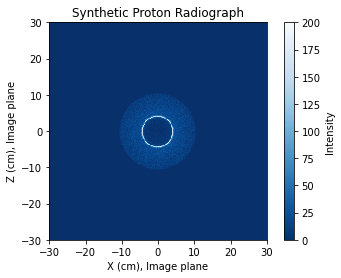

In [6]:
size = np.array([[-30,30],[-30,30]])*1e-2
bins = [250,250]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)

fig, ax = plt.subplots()
plot = ax.pcolormesh(hax.to(u.cm).value, vax.to(u.cm).value,
                     intensity.T, cmap='Blues_r')

cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity")

ax.set_aspect('equal')
ax.set_xlabel('X (cm), Image plane')
ax.set_ylabel('Z (cm), Image plane')
ax.set_title("Synthetic Proton Radiograph")